In [1]:
from DataManipulation.DataHandler import getOHLC_pickle
data = getOHLC_pickle("EURUSD_M_2010_2021.pkl")
data = data.resample('1H').agg({'Open': 'first', 
                        'High': 'max', 
                        'Low': 'min', 
                        'Close': 'last'}).dropna()

In [2]:
#generates the indicators
from DataManipulation.indicators import DEMA, D1, MaxMinRollNorm
demaperiod = [9]
for p in demaperiod:
    data['dema'+str(p)] = DEMA(data['Close'],p)
    data['D1dema'+str(p)] = D1(data['dema'+str(p)])
#    data['normD1dema'+str(p)] = MaxMinRollNorm(data['D1dema'+str(p)], 24*250) # 250 approximated larger than all trading days in a year

stdperiod = [9,100,300]
for p in stdperiod:
    data['std'+str(p)+"_dema9"]  = data['dema9'].rolling(p).std()
    data['std'+str(p)+"_D1dema9"]= data['D1dema9'].rolling(p).std()
print(data.columns)

Index(['Open', 'High', 'Low', 'Close', 'dema9', 'D1dema9', 'std9_dema9',
       'std9_D1dema9', 'std100_dema9', 'std100_D1dema9', 'std300_dema9',
       'std300_D1dema9'],
      dtype='object')


In [34]:
import numpy as np
import pandas as pd
x = pd.Series([np.nan,1,2,3,4,5,6,7,8,9])
y = pd.Series([np.nan,2,3,4,5,6,7,8,9,10])
print((x[1:]-y[:-1]).shape)
print((x[1:]-y[:-1]))
print((x[1:].to_numpy()-y[:-1].to_numpy()))

(10,)
0    NaN
1   -1.0
2   -1.0
3   -1.0
4   -1.0
5   -1.0
6   -1.0
7   -1.0
8   -1.0
9    NaN
dtype: float64
[nan  0.  0.  0.  0.  0.  0.  0.  0.]


In [3]:
import pandas as pd
prediction_ind = ['D1dema9','std9_dema9','std9_D1dema9', 'std100_dema9', 'std100_D1dema9', 'std300_dema9','std300_D1dema9']
preds = pd.DataFrame()
for n in prediction_ind:
    preds[n+"_norm"] = MaxMinRollNorm(data[n], 24*250)
preds.tail()

,D1dema9_norm,std9_dema9_norm,std9_D1dema9_norm,std100_dema9_norm,std100_D1dema9_norm,std300_dema9_norm,std300_D1dema9_norm
Date,,,,,,,
2021-09-30 19:00:00,0.549541,0.035342,0.157625,0.417056,0.216130,0.387081,0.228713
2021-09-30 20:00:00,0.509068,0.031738,0.166833,0.421059,0.216888,0.390208,0.211806
2021-09-30 21:00:00,0.593398,0.035424,0.145746,0.424265,0.215617,0.392990,0.210738
2021-09-30 22:00:00,0.599056,0.033126,0.123020,0.426708,0.215817,0.395560,0.211329
2021-09-30 23:00:00,0.585908,0.033670,0.104754,0.428453,0.214252,0.397978,0.211484


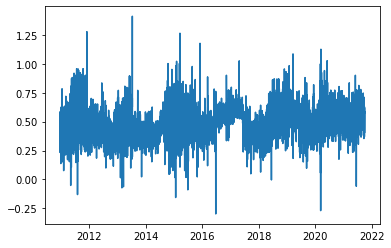

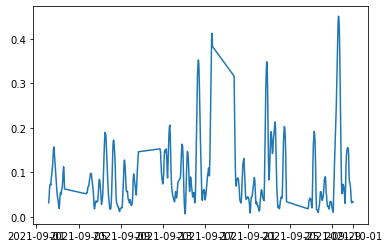

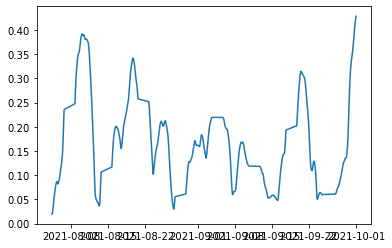

In [4]:
import matplotlib.pyplot as plt
plt.plot(preds['D1dema9_norm'].iloc[:]) # might consider to only divide, not subtract minimum as direction might be useful?
plt.show()
plt.plot(preds['std9_dema9_norm'].iloc[-500:])
plt.show()
plt.plot(preds['std100_dema9_norm'].iloc[-1000:])
plt.show()

In [6]:
from numpy.lib.stride_tricks import sliding_window_view
raw =  preds.dropna().to_numpy()
wind = sliding_window_view(raw,window_shape = 3*5*24, axis=0)
#print(wind[-1,:])
print(wind.shape)
#print(wind[~pd.isna(wind)].shape)
x = wind[:-1,:]
target_column = "std100_dema9_norm"
y = wind[1:,3,-1]
print(x.shape,y.shape)

(66390, 7, 360)
(66389, 7, 360) (66389,)


In [32]:
from torch.utils.data import TensorDataset
import torch
train_x = torch.Tensor(x[0:int(len(x)*0.7),])
train_y = torch.Tensor(y[0:int(len(x)*0.7)]).unsqueeze(1)
test_x  = torch.Tensor(x[int(len(x)*0.7):,])
test_y  = torch.Tensor(y[int(len(x)*0.7):]).unsqueeze(1)

train_dataset = TensorDataset(torch.Tensor(x[0:int(len(x)*0.7),]),torch.Tensor(y[0:int(len(x)*0.7)]).unsqueeze(1) )
test_dataset =  TensorDataset(torch.Tensor(x[int(len(x)*0.7):,]), torch.Tensor(y[int(len(x)*0.7):]).unsqueeze(1) )

trainloader = torch.utils.data.DataLoader(train_dataset,
                            batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset,
                            batch_size=32, shuffle=True)


In [25]:
import torch
from torch import optim
from Models.neural import STDConvModel
model = STDConvModel(3*5*24, 7, 12,stride1=2,stride2=2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = model.to(device)
class reverseKLD(torch.nn.Module):
    """
    Class for creating a custom loss function, if desired.
    If you instead specify a standard loss function,
    you can remove or comment out this class.
    """
    def __init__(self):
        super(reverseKLD, self).__init__()
        self.loss = torch.nn.KLDivLoss()
    def forward(self, output, target):
        #return torch.mean((output - target)**2)
        return self.loss(target,output)
criterion = reverseKLD()
optimiser = optim.Adam(net.parameters())

In [26]:
def test_network(net,testloader, criterion):
    net.eval()
    total_images = 0
    #total_correct = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
    #        _, predicted = torch.max(outputs.data, 1)
            loss = criterion(output,labels)
            total_images += labels.size(0)
    #        total_correct += (predicted == labels).sum().item()

    model_accuracy = total_correct / total_images * 100
    #print('      Accuracy on {0} test images: {1:.2f}%'.format(
    #                            total_images, model_accuracy))
    print("Test Loss: ", loss)
    net.train()

In [30]:
print("Start training...")
for epoch in range(0,2):
    total_loss = 0
    total_timeframes = 0
    #total_correct = 0

    for batch in trainloader:           # Load batch
        batch_x, batch_y = batch 
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        preds = net(batch_x)             # Process batch
        #print(preds.shape,batch_y.shape)
        loss = criterion(preds, batch_y) # Calculate loss

        optimiser.zero_grad()
        loss.backward()                 # Calculate gradients
        optimiser.step()                # Update weights

        output = preds.argmax(dim=1)

        total_loss += loss.item()
        total_timeframes += batch_y.size(0)
        #total_correct += output.eq(labels).sum().item()
    #scheduler.step()
    #model_accuracy = total_correct / total_images * 100
    print('epoch {0} total_correct: {1} loss: {2:.2f} acc: {3:.2f}'.format(
                epoch,-1, total_loss, -1) )
    
    #if epoch % 10 == 0:
    #    #if student.train_val_split < 1:
    #    test_network(net,testloader)
    #    torch.save(net.state_dict(), 'checkModel.pth')
    #    print("      Model saved to checkModel.pth")
    #    elapsed = time.time() - t
    #    print(elapsed)
    
#if student.train_val_split < 1:
#    test_network(net,testloader)
#torch.save(net.state_dict(), 'savedModel.pth')
#print("   Model saved to savedModel.pth")

Start training...
epoch 0 total_correct: -1 loss: 0.00 acc: -1.00
epoch 1 total_correct: -1 loss: 0.00 acc: -1.00


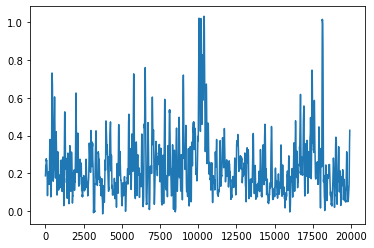

torch.Size([19917, 1])
tensor([[nan]], grad_fn=<TanhBackward0>)


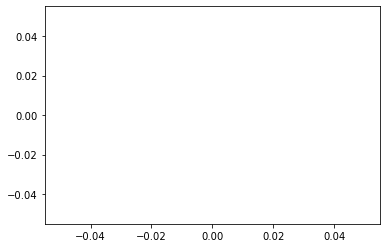

In [43]:
import matplotlib.pyplot as plt

plt.plot(test_y)
plt.show()
plt.plot(net(test_x).detach().numpy())

print(test_y.shape)
#print(net(test_x).detach().numpy().shape)
#print(net(test_x).detach().numpy()[-20:])
print(net.)

In [3]:
import torch
from Models.neural import STDConvModel
m1 = STDConvModel(3*5*24, 2, 12,stride1=2,stride2=2)
m2 = STDConvModel(3*5*24, 2, 12,stride1=1,stride2=1)
from torchinfo import summary
print(m1(torch.zeros((20,2,5*24))).shape)
#print(summary(m1,(20,2,5*24)))
#print(summary(m2,(20,2,5*24)))

torch.Size([20, 1])
